# One Qubit PER

Carry out canonical noise scaling on one qubit

In [1]:
#helper libraries
import numpy as np
from numpy.random import randint
import matplotlib.pyplot as plt
from decimal import Decimal
from numpy.random import permutation

#qiskit functionalities
from qiskit import Aer, execute, QuantumCircuit

#noise model stuff
from qiskit.providers.aer.noise import NoiseModel, kraus_error
    
#operator info
from qiskit.quantum_info import Pauli, Kraus

## Create noise model

Use the model parameters to create a noise model

In [2]:
F = [Pauli("I"), Pauli("X"), Pauli("Y"), Pauli("Z")] #list of Paulis
T = [Pauli("X"), Pauli("Y"), Pauli("Z")] #These are the terms considered in the model
coeffs = [.01, .01, .01] #These are the corresponding lambdas
omegas = np.multiply(.5, np.add(1, np.exp(np.multiply(-2.0, coeffs)))) #Equation (S9)
gamma = np.exp(2.0*np.sum(coeffs)) #below Eq (5)

In [3]:
kraus_ops = Kraus(np.identity(2)) #Start with identity map

#Repeatedly compose (w_kI+(1-w_k)P_k) to get error channel as Kraus map
for i in range(len(T)):
    op = Kraus([T[i].to_matrix()*np.sqrt(1-omegas[i]),np.sqrt(omegas[i])*np.identity(2)]);
    kraus_ops = kraus_ops.compose(op);

kraus_error_channel = kraus_error(kraus_ops.data) #create kraus error channel from kraus map
kraus_noise_model = NoiseModel() #create noise model from kraus error channel
kraus_noise_model.add_all_qubit_quantum_error(kraus_error_channel, ['id', 'rx', 'ry', 'rz']) #add noise to all gates
kraus_basis_gates = kraus_noise_model.basis_gates #get noisy basis gates

/home/ben/.local/lib/python3.10/site-packages/qiskit/quantum_info/operators/channel/kraus.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if isinstance(data, np.ndarray) or np.array(data).ndim == 2:


## Canonical Noise Scaling

Canonical noise scaling involves separating the distribution into the negative and positive volumes by the sign of the coefficients. Given a QPD representation of a unitary $\mathcal{U}$ in terms of noisy gates $\mathcal{O}_\alpha\in \mathcal{I}$,
$$
\mathcal{U} = \sum_{\alpha} \eta_\alpha \mathcal{O}_\alpha
$$
the indices $\alpha$ corresponding to negative and positive coefficients can be separated into two sets:
$$
D^{\pm} = \{\alpha \ | \ \eta_\alpha \gtrless 0\}
$$
Then the gates corresponding to each set can be used to construct a TPCP operator:
$$
\Phi^{\pm} = \frac{1}{\gamma^{\pm}}\sum_{\alpha \in D^{\pm}}|\eta_\alpha| \mathcal{O}_\alpha
$$
Where the overhead is selected so that the operator is trace-preserving:
$$
\gamma^{\pm} = \sum_{\alpha \in D^{\pm}}|\eta_\alpha|
$$
Then $\mathcal{U}$ can be written in terms of these channels:
$$
\mathcal{U} = \gamma^+ \Phi^+ - \gamma^- \Phi^-
$$
A noisy gate $\mathcal{U}^\lambda$ can be parameterized as
$$
\mathcal{U}^\lambda = (\gamma^+-\lambda \gamma^-)\Phi^+-(1-\lambda)\gamma^-\Phi^-
$$
This has the convenient property that at $\lambda = 0$ it reduces to the ideal QPD, at $\lambda = 1$ it reduces to $\Phi^+$ representing around hardware noise level, and at $\lambda = \frac{\gamma^+}{\gamma^-}$ it reduces to $\Phi^-$, representing the greatest level of noise.

Lastly, the overheads $\gamma^+$ and $\gamma^-$ can be computed in terms of $\gamma$, using the equations
$$
\gamma^+-\gamma^- = 1\\
\gamma^+ + \gamma^- = \gamma
$$
Which hold when $\lambda < 1$. Adding and subtracting these yields
$$
\gamma^+ = \frac{\gamma+1}{2}\\
\gamma^- = \frac{\gamma-1}{2}
$$

## Separating negative and positive volumes

I was unsure about the best way to go about this. The solution I came up with was using the fact that the inverse channel $\Lambda^{-1}$ is defined by the inverse fidelities $\frac{1}{f_a}$ to convert the inverse to a Pauli channel via

$$
\Lambda^{-1}(\rho) = \sum_k c_k P_k \rho P_k \ \ \text{where} \ \ c_k = \frac{1}{4^n}\sum_j (-1)^{\langle j, k \rangle} \frac{1}{f_a}
$$

This is done in the following cell:

In [4]:
def s_prod(j, k): #symplectic inner product
    return {True:0,False:1}[F[j].compose(F[k]) == F[k].compose(F[j])]

M = [[s_prod(j,k) for k in range(len(F))] for j in range(len(F))] #Matrix expressing commutativity

f = np.exp(np.multiply(-2.0, np.dot(M,[0]+coeffs))) #find ideal fidelities
        
def WHtransform(k): #Walsh-Hadamard transform with inverse fidelities
    return 1/4*np.sum([(-1)**s_prod(k,j)*1/f[j] for j in range(len(F))])
    
pauli_coeffs = [WHtransform(k) for k in range(len(F))] #get coefficients

Compute positive and negative volumes and scale them into probability distributions

In [5]:
Dplus = [(P, c) for (P,c) in zip(F,pauli_coeffs) if c > 0]
Dminus = [(P, c) for (P,c) in zip(F,pauli_coeffs) if c < 0]

pos_dist = [np.abs(c) for (P,c) in Dplus]
neg_dist = [np.abs(c) for (P,c) in Dminus]

pos_overhead = np.sum(pos_dist)
neg_overhead = np.sum(neg_dist)

pos_dist = np.divide(pos_dist, pos_overhead)
neg_dist = np.divide(neg_dist, neg_overhead)

In [6]:
#I wanted to be able to control the precision of the rng
def rand_precision(prec_digits):
    return Decimal(randint(0, 10**prec_digits))/10**prec_digits

def sample(dist):
    r = rand_precision(10)
    return min([i for (i,a) in enumerate(np.cumsum(dist)) if a > r])

def mitigation(gate_to_mitigate, samples, lmbda):
    total = 0 #stores the estimator value
    gammaplus = .5*(gamma+1)
    gammaminus = .5*(gamma-1)
    
    backend = Aer.get_backend('qasm_simulator') #backend is a simulator (for now)
    
    dist = np.divide(np.abs(pauli_coeffs),gamma)
    for i in range(samples):
        op = gate_to_mitigate
        if rand_precision(10) < (gammaplus-lmbda*gammaminus)/(gamma - lmbda*(gamma-1)):
            # sample from positive distribution
            m = 1
            (P,c) = Dplus[sample(pos_dist)]
            op = op.compose(P)
        else:
            # sample from negative distribution
            m = -1
            (P,c) = Dminus[sample(neg_dist)]
            op = op.compose(P)
            
        qc = QuantumCircuit(1,1) 
        qc.append(op.to_instruction(),[0]) #apply combination of paulis in circuit
        qc.measure(0,0)
        
        #run one shot of this circuit
        counts = execute(qc, backend, noise_model=kraus_noise_model, 
                        basis_gates = kraus_basis_gates, shots = 1,
                        optimization_level = 0).result().get_counts()
        
        total += (counts.get('0',0)-counts.get('1',0))*m #scale the results accordingly
        
    return total * (gamma - lmbda*(gamma-1)) / samples
        

In [28]:
from decimal import Decimal
samples = 1000
totals = {'I':0, 'X':0, 'Y':0, 'Z':0}
total = 0
w = .5*(1+np.exp(-.1))
backend = Aer.get_backend('qasm_simulator')
probs = [w*(1-w)*(2*w-1), w**3-(1-w)**3, w*(1-w)*(2*w-1),w*(1-w)*(2*w-1)]
gamma = np.sum(probs)
dist = np.divide(probs,gamma)
print(dist)

for i in range(samples):
    j = sample(dist)
    op = F[j]
    qc = QuantumCircuit(1,1)
    qc.append(op.to_instruction(),[0])
    qc.measure(0,0)
    count = execute(qc, backend, shots = 1, optimization_level = 0, noise_model = kraus_noise_model, basis_gates = kraus_basis_gates).result().get_counts()
    m = -1
    if j == 1:
        m = 1
    totals[str(F[j])] += m
    #(count.get('0',0)-count.get('1',0))*m

print([totals[key]*gamma/samples for key in totals.keys()])
exp = w**3+(1-w)**3-w*(1-w)
print((totals['I']*exp-totals['X']*exp-totals['Y']*exp+totals['Z']*exp)/samples*gamma)


[0.04155132 0.87534603 0.04155132 0.04155132]
[-0.04638180978551478, 0.8546095164735277, -0.04539496276880171, -0.0404607276852363]
-0.7336294970589642


In [29]:
print(exp)

0.8187307530779817


## Find estimator for different values of $\lambda$

In [10]:
lmbdas = [0, .2, .6, 1]
mitigated_values = []
samples = 1000
#Run the procedure for each lambda
for lmbda in lmbdas:
    mitigated_value = mitigation(Pauli('X'), samples, lmbda)
    mitigated_values.append(mitigated_value)

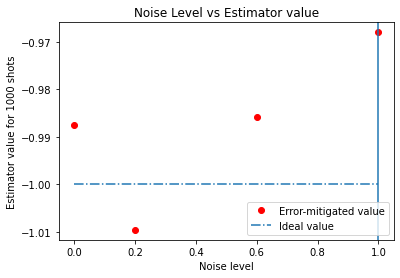

In [11]:
xrange = np.linspace(0, max(lmbdas), 100)
mv, = plt.plot(lmbdas, mitigated_values, 'ro')
iv, = plt.plot(xrange, [-1]*len(xrange), '-.')
plt.xlabel("Noise level")
plt.ylabel("Estimator value for %s shots" %samples)
plt.axvline(1)
plt.title("Noise Level vs Estimator value")
plt.legend([mv, iv], ['Error-mitigated value', 'Ideal value'], loc="lower right")